# Python Version 

In [1]:
!sudo apt-get update -y
!sudo apt-get install python3.10
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 2
!python --version

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [902 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,528 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backpo

# Import  Libraries

In [65]:
import os 
import json
import math
import torch
import torchvision
import shutil
import warnings
warnings.filterwarnings("ignore")


import numpy as np
import torch.nn as nn
import torch.cuda as cuda
import torchvision.transforms as T
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt




from tqdm import tqdm
from statistics import mean
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from torch import Tensor
from torchvision import models
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Subset
from torch.nn import CrossEntropyLoss
from torch.optim import RMSprop, Adagrad
from torch.utils.tensorboard import SummaryWriter

try: 
  import tensorboard
except: 
  !pip install tensorboard 

try: 
  from overrides import overrides, final
except: 
  pass

from abc import abstractmethod
from google.colab import drive
from __future__ import annotations



# HyperParameters

In [88]:
# Device Settings
seed = 42

# Data Transformation
path = "./adaptiope_small/"
source = "product_images/"
target = "real_life/"
resize_dim = 256
crop_dim = 224
grayscale = False
crop_center = True

# Data Loader
batch_size = 30 #60
test_split = 0.2

# Feature Extractor
n_classes = 20
freeze = True
model = 'resnet50'
optim = 'rmsprop'
n_params_trained = 10
weight_decay = 1e-4
lr = 1e-4

# Model Trainer
n_epochs = 20 #250

# Device Settings

In [4]:
np.random.seed(seed)
torch.manual_seed(seed)
if cuda.is_available():
    print('You\'re running on GPU')
    cuda.manual_seed(seed)
    gpu = True
else:
    print('You\'re running on CPU')
    gpu = False

You're running on GPU


In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug  7 08:16:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
ram_gb = round(ram_gb, 2)
print(f'{ram_gb} GB of RAM\n')

27.33 GB of RAM



# Load Dataset

In [7]:
drive.mount('/content/drive', force_remount=True)

if not os.path.exists('/content/adaptiope_small'):
  !mkdir "/content/dataset"
  !cp "/content/drive/My Drive/DLL_project/Adaptiope.zip" "/content/dataset/"
  !ls "/content/dataset"
  !unzip "/content/dataset/Adaptiope.zip"
  !rm -rf "/content/adaptiope_small"
  !mkdir "/content/adaptiope_small"



Output streaming troncato alle ultime 5000 righe.
  inflating: Adaptiope/synthetic/purse/purse_1_19.png  
  inflating: Adaptiope/synthetic/purse/purse_2_16.png  
  inflating: Adaptiope/synthetic/purse/purse_4_16.png  
  inflating: Adaptiope/synthetic/purse/purse_3_03.png  
  inflating: Adaptiope/synthetic/purse/purse_3_16.png  
  inflating: Adaptiope/synthetic/purse/purse_1_17.png  
  inflating: Adaptiope/synthetic/purse/purse_2_05.png  
  inflating: Adaptiope/synthetic/purse/purse_3_08.png  
  inflating: Adaptiope/synthetic/purse/purse_2_07.png  
  inflating: Adaptiope/synthetic/purse/purse_2_17.png  
  inflating: Adaptiope/synthetic/purse/purse_3_00.png  
  inflating: Adaptiope/synthetic/purse/purse_1_09.png  
  inflating: Adaptiope/synthetic/purse/purse_4_18.png  
  inflating: Adaptiope/synthetic/purse/purse_3_05.png  
  inflating: Adaptiope/synthetic/purse/purse_3_01.png  
  inflating: Adaptiope/synthetic/purse/purse_4_08.png  
  inflating: Adaptiope/synthetic/purse/purse_4_09.png 

In [8]:
classes = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", "flat iron", "game controller", "glasses",
           "helicopter", "ice skates", "letter tray", "monitor", "mug", "network switch", "over-ear headphones", "pen",
           "purse", "stand mixer", "stroller"]

In [9]:
for d, td in zip(["Adaptiope/product_images", "Adaptiope/real_life"], ["adaptiope_small/product_images", "adaptiope_small/real_life"]):
  if not os.path.exists(td):
    os.makedirs(td)
    for c in tqdm(classes):
      c_path = os.path.join(d, c)
      c_target = os.path.join(td, c)
      shutil.copytree(c_path, c_target)

100%|██████████| 20/20 [00:00<00:00, 30.44it/s]


# Data Transformation

In [10]:
def data_transformation(resize_dim = 256, crop_dim = 224, grayscale = True, crop_center = True):
    transform_lst = []
    transform_lst.append(T.Resize((resize_dim)))                                                          
    
    if grayscale:
        transform_lst.append(T.Grayscale(num_output_channels=3))                        
    
    if crop_center:
        transform_lst.append(T.CenterCrop((crop_dim)))
    else:
        transform_lst.append(T.RandomCrop((crop_dim)))
    
    transform_lst.append(T.RandomHorizontalFlip(p=0.5))                                  
    transform_lst.append(T.ToTensor())                                             
        
    return T.Compose(transform_lst)  



In [11]:
def normalization(dataset):
    ds_length = len(dataset)
    for i in tqdm(range(ds_length)):
        r_mean, g_mean, b_mean = torch.mean(dataset[i][0], dim = [1,2])
        r_std, g_std, b_std = torch.std(dataset[i][0], dim = [1,2])
        T.functional.normalize(
            tensor = dataset[i][0], 
            mean = [r_mean, g_mean, b_mean],
            std = [r_std, g_std, b_std],
            inplace=True)
    return dataset

In [12]:
root = path + source

source_ds = torchvision.datasets.ImageFolder(
    root = path + source,
    transform = data_transformation(
        resize_dim, 
        crop_dim, 
        grayscale, 
        crop_center))

target_ds = torchvision.datasets.ImageFolder(
    root = path + target, 
    transform = data_transformation(
        resize_dim, 
        crop_dim, 
        grayscale, 
        crop_center)) 

if not grayscale:
    normalization(source_ds)
    normalization(target_ds)

100%|██████████| 2000/2000 [03:17<00:00, 10.12it/s]


# Data Loader 

In [13]:
def get_data(dataset, test_split=0.2, batch_size=32):
    
    train_indices, val_indices = train_test_split(
        list(range(len(dataset.targets))),
        test_size = test_split,
        stratify = dataset.targets, 
        random_state = 42)
    
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_data_loader, val_data_loader
    

In [14]:
source_train_loader, source_val_loader = get_data(source_ds, test_split, batch_size)
target_train_loader, target_val_loader = get_data(target_ds, test_split, batch_size)

# UDA Architecture 

## Losses

In [82]:
class _Loss(nn.Module):
    
    _THRESHOLD = 1e-20
    
    def __init__(self):
        super(_Loss, self).__init__()
        
    def forward(self, input: Tensor):
        prob = self.to_softmax(input)
        loss = self.compute_loss(prob)
        if cuda.is_available():
            loss = loss.cuda()
        return loss
        
    ### @final
    def add_threshold(self, prob: Tensor):
        '''
        Check whether the probability distribution after the softmax 
        is equal to 0 in any cell. If this holds, a standard threshold
        is added in order to avoid log(0) case. 

        Parameters
        ----------
        prob: Tensor
            output tensor of the softmax operation

        Returns
        -------
        Tensor
            updated tensor (in case the condition above holds)
        '''
        zeros = (prob == 0)
        if torch.any(zeros):
            thre_tensor = torch.zeros(zeros.shape)
            if cuda.is_available():
                thre_tensor = thre_tensor.cuda()
            thre_tensor[zeros] = self._THRESHOLD
            prob = prob + thre_tensor
        if cuda.is_available():
            prob = prob.cuda()
        return prob
    
    def to_softmax(self, features: Tensor):
        '''
        Apply the softmax operation on the features tensor, 
        being the output of a feature extractor. 
        
        Parameters
        ----------
        features: Tensor
            input tensor of the softmax operation

        Returns
        -------
        Tensor
            probability distribution with (possible) threshold
        '''
        prob = F.softmax(features, dim=1)
        prob = self.add_threshold(prob)
        if cuda.is_available():
            prob = prob.cuda()
        return prob
    
    @abstractmethod
    def compute_loss(self, prob: Tensor):
        pass

In [83]:
class EntropyMinimizationLoss(_Loss):
    
    def __init__(self, n_classes: int):
        super(EntropyMinimizationLoss, self).__init__()
        self.n_classes = n_classes
    
    ### @overrides
    def compute_loss(self, prob: Tensor):
        prob_source = prob[:, :self.n_classes]
        prob_target = prob[:, self.n_classes:]
        prob_sum = prob_source + prob_target
        loss = -(prob_sum.log().mul(prob_sum).sum(dim=1).mean())
        if cuda.is_available():
            loss = loss.cuda()
        return loss

In [84]:
class SplitLoss(_Loss):
    
    def __init__(self, n_classes: int, source: bool, split_first: bool):
        super(SplitLoss, self).__init__()
        self.n_classes = n_classes
        self._is_source = source
        self._split_first = split_first
    
    ### @overrides
    def to_softmax(self, features: Tensor):
        if self._split_first:
            prob = self.split_vector(features)
            prob = F.softmax(prob, dim=1)
        else:
            prob = F.softmax(features, dim=1)
            prob = self.split_vector(prob)
        prob = self.add_threshold(prob)
        if cuda.is_available():
            prob = prob.cuda()
        return prob
    
    ### @final
    def split_vector(self, prob: Tensor):
        return prob[:,:self.n_classes] if self._is_source else prob[:,self.n_classes:]

In [85]:
class SplitCrossEntropyLoss(SplitLoss):
    
    def _get_y_labels(self) -> Tensor:
        return self._y_labels
    def _set_y_labels(self, y_labels: list):
        # if not all(y < self.n_classes for y in y_labels):
        #    raise ValueError('Expected all y labels < n_classes')
        dev = 'cuda:0' if cuda.is_available() else 'cpu:0'
        y_labels_tns = torch.tensor(y_labels, dtype=torch.long, device=dev)
        self._y_labels = F.one_hot(y_labels_tns, num_classes=self.n_classes)
        self._y_labels = self._y_labels.type(torch.float)
    y_labels = property(fget=_get_y_labels, fset=_set_y_labels)
    
    def __init__(self, n_classes: int, source: bool, split_first: bool):
        super(SplitCrossEntropyLoss, self).__init__(n_classes, source, split_first)
        self.cross_entropy_loss = CrossEntropyLoss(reduction='mean', label_smoothing=0.2)
        if cuda.is_available():
            self.cross_entropy_loss = self.cross_entropy_loss.cuda()
    
    ### @overrides
    def compute_loss(self, prob: Tensor):
        # assert prob.size() == self.y_labels.size()
        loss = self.cross_entropy_loss(prob, self.y_labels)
        if cuda.is_available():
            loss = loss.cuda()
        return loss

In [86]:
class DomainDiscriminationLoss(SplitLoss):
    
    def __init__(self, n_classes: int, source: bool):
        super(DomainDiscriminationLoss, self).__init__(n_classes, source, False)
        
    ### @overrides
    def compute_loss(self, prob: Tensor):
        loss = -(prob.sum(dim=1).log().mean())
        if cuda.is_available():
            loss = loss.cuda()
        return loss

In [87]:
class TrainingObjectives:
    
    @staticmethod
    def domain_discrimination_loss(src_dom_discrim_loss, tgt_dom_discrim_loss):
        return src_dom_discrim_loss + tgt_dom_discrim_loss
    
    @staticmethod
    def category_confusion_loss(src_cat_conf_loss, tgt_cat_conf_loss):
        return 0.5 * (src_cat_conf_loss + tgt_cat_conf_loss)
    
    @staticmethod
    def domain_confusion_loss(src_dom_conf_loss, tgt_dom_conf_loss):
        return 0.5 * (src_dom_conf_loss + tgt_dom_conf_loss)
    
    @staticmethod
    def overall_classifier_loss(src_task_class_loss, tgt_task_class_loss, domain_discrim_loss):
        return src_task_class_loss + tgt_task_class_loss + domain_discrim_loss
    
    @staticmethod
    def overall_generator_loss(cat_conf_loss, dom_conf_loss, tgt_entropy_loss, curr_epoch, tot_epochs):
        lambda_trade_off = 2 / (1 + math.exp(-1 * 10 * curr_epoch / tot_epochs)) - 1
        return cat_conf_loss + lambda_trade_off * (dom_conf_loss + tgt_entropy_loss)

## Feature Extractor

In [21]:
class FeatureExtractor:
    
    def __init__(self, n_classes: int, model='resnet50', optimizer='rmsprop', n_params_trained=None, freeze=False, lr=0.01, weight_decay=0, source_only=False):
        """_summary_

        Args:
            n_classes (int): number of classes present in the dataset
            n_params_trained (_type_, optional): Number of parameters (i.e., layers to be trained). Defaults to None.
            model (str, optional): Pretrained model to import as feature extractor. Defaults to 'resnet18'.
            optimizer (str, optional): Optimizer for the model. Defaults to 'rmsprop'.
            lr (float, optional): Initial learning rate. Defaults to 0.01.
            weight_decay (int, optional): Initial weight decay. Defaults to 0.
        """
        self.lr = lr
        
        # Upload pretrained model 
        if model.lower() == 'resnet18': 
            self.model = models.resnet18(pretrained=True)
        elif model.lower() == 'resnet50': 
            self.model = models.resnet50(pretrained=True)
        else:
            raise ValueError('Unknown model')
        
        # Modify last fully-connected layer
        if not source_only: 
            self.model.fc = nn.Linear(
                in_features = self.model.fc.in_features, 
                out_features = n_classes * 2)
        else:
            self.model.fc = nn.Linear(
                in_features = self.model.fc.in_features, 
                out_features = n_classes) 
        
        if cuda.is_available():
            self.model = self.model.cuda()

        n_params = len(list(self.model.parameters()))
        if n_params_trained is None:
            n_params_trained = n_params
        
        count = 0 
        first_param_trained = n_params - n_params_trained
        
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = (count >= first_param_trained)
                count = count + 1 
            params_to_train = filter(lambda p: p.requires_grad, self.model.parameters())
        else:
            # Layer-wise Learning Rate Decay
            i = -1 
            params_to_train = []
            name_prev_group = None
            groups = set([name.split('.')[0] for name, _ in self.model.named_parameters()])
            for name, param in self.model.named_parameters():
                name_cur_group = name.split('.')[0]
                if name_cur_group != name_prev_group or name_prev_group is None:
                    i = i + 1
                    # NOTE: At half groups corresponds half learning rate
                    lr_group = self.decay(i, len(groups)-1)
                name_prev_group = name_cur_group
                params_to_train.append({'params': param, 'lr': lr_group})
            
        # Initialize optimizer
        if optimizer.lower() == 'rmsprop':
            self.optim = torch.optim.RMSprop(
                params = params_to_train,
                lr = lr,
                weight_decay = weight_decay)
        elif optimizer.lower() == 'adadelta':
            self.optim = torch.optim.Adadelta(
                params = params_to_train,
                lr = lr,
                weight_decay = weight_decay)
        elif optimizer.lower() == 'sgd':
            self.optim = torch.optim.SGD(
                params = params_to_train,
                lr = lr,
                weight_decay = weight_decay,
                nesterov = True)
        else:
            raise ValueError('Unknown optimizer')
    
    def decay(self, index: int, n_groups: int):
        lr_steep = 10
        sigmoid = lambda x: 1/(1 + np.exp(-x)) 
        return self.lr * sigmoid(lr_steep/n_groups * (index - (n_groups/2))) 
            
        

## Loader 

In [22]:
class ModelLoader:
    
    def __init__(self, base_dir: str, filename: str):
        self.base_dir = base_dir
        self.filename = filename
        self.fullpath = f'{base_dir}/{filename}'
    
    def check_base_dir(self):
        try:
            if not os.path.exists(self.base_dir):
                os.makedirs(self.base_dir)
            return True
        except OSError:
            return False

    def model_save(self, model, optimizer):
        if self.check_base_dir(): 
            with open(f'{self.fullpath}.pickle', 'wb') as f:
                torch.save([model, optimizer], f)
        else:
            raise Exception('Model saving failed')

    def model_load(self):
        if self.check_base_dir():
            with open(f'{self.fullpath}.pickle', 'rb') as f:
                model, optimizer = torch.load(f)
                return model, optimizer
        else:
            raise Exception('Model loading failed')
    
    def save_hyperparam(self):
        params_dict = {
            'seed': seed,
            'source': source,
            'target': target,
            'resize_dim': resize_dim,
            'crop_dim': crop_dim,
            'grayscale': grayscale,
            'crop_center': crop_center,
            'batch_size': batch_size,
            'test_split': test_split,
            'n_classes': n_classes,
            'freeze': freeze,
            'model': model,
            'optimizer': optim,
            'n_params_trained': n_params_trained,
            'weight_decay': weight_decay,
            'learning_rate': lr,
            'n_epochs': n_epochs
        }
        if self.check_base_dir():
            with open(f'{self.fullpath}_params.json', 'w') as f:
                json.dump(params_dict, f, indent=4)
        else:
            raise Exception('Hyperparams saving failed')
            
    def save_results(self, results: dict):
        if self.check_base_dir():
            with open(f'{self.fullpath}_results.json', 'w') as f:
                json.dump(results, f, indent=4)
        else:
            raise Exception('Results saving failed')

## Trainer

In [79]:
class ModelTrainer:
    
    _INF = 1e20
    _LAST = 5
    
    def __init__(self, model: FeatureExtractor, loader: ModelLoader, n_classes: int, epochs: int):
        """Initialize the SymsNet model
        Args:
            model (FeatureExtractor): _description_
            n_classes (int): _description_
            epochs (int): _description_
        """
        self.curr_epoch = 0
        self.tot_epochs = epochs
        self.n_classes = n_classes
        self.model = model
        self.loader = loader
        self.patience = 10 
        self.src_task_class_loss = SplitCrossEntropyLoss(n_classes=n_classes, source=True, split_first=True)
        self.tgt_task_class_loss = SplitCrossEntropyLoss(n_classes=n_classes, source=False, split_first=True)
        # Domain discrimination losses
        self.src_dom_discrim_loss = DomainDiscriminationLoss(n_classes=n_classes, source=True)
        self.tgt_dom_discrim_loss = DomainDiscriminationLoss(n_classes=n_classes, source=False)
        # Category-level confusion losses
        self.src_cat_conf_loss = SplitCrossEntropyLoss(n_classes=n_classes, source=True, split_first=False)
        self.tgt_cat_conf_loss = SplitCrossEntropyLoss(n_classes=n_classes, source=False, split_first=False)
        # Domain-level confusion losses
        self.src_dom_conf_loss = DomainDiscriminationLoss(n_classes=n_classes, source=True)
        self.tgt_dom_conf_loss = DomainDiscriminationLoss(n_classes=n_classes, source=False)
        # Entropy minimization loss
        self.tgt_entropy_loss = EntropyMinimizationLoss(n_classes=n_classes)   

        if cuda.is_available():
            # Task classifier losses
            self.src_task_class_loss = self.src_task_class_loss.cuda()
            self.tgt_task_class_loss = self.tgt_task_class_loss.cuda()
            # Domain discrimination losses
            self.src_dom_discrim_loss = self.src_dom_discrim_loss.cuda()
            self.tgt_dom_discrim_loss = self.tgt_dom_discrim_loss.cuda()
            # Category-level confusion losses
            self.src_cat_conf_loss = self.src_cat_conf_loss.cuda()
            self.tgt_cat_conf_loss = self.tgt_cat_conf_loss.cuda()
            # Domain-level confusion losses
            self.src_dom_conf_loss = self.src_dom_conf_loss.cuda()
            self.tgt_dom_conf_loss = self.tgt_dom_conf_loss.cuda()
            # Entropy minimization loss
            self.tgt_entropy_loss = self.tgt_entropy_loss.cuda()    

    def train_step(self, X_source: Tensor, y_source: Tensor, X_target: Tensor):
        # Tell model go training mode
        self.model.model.train()
        # Compute features for both inputs
        y_source_pred = self.model.model(X_source)
        y_target_pred = self.model.model(X_target)
        # Compute overall training objective losses
        classifier_loss, generator_loss = self.overall_losses(
            y_source_pred, 
            y_target_pred, 
            y_source)
        # Compute gradients w.r.t. classifier loss
        self.model.optim.zero_grad()
        classifier_loss.backward(retain_graph=True)
        grad_classifier_tmp = []
        for p in self.model.model.parameters():
            if p.grad is not None:
                grad_classifier_tmp.append(p.grad.data.clone())
        # Compute gradients w.r.t. generator loss
        self.model.optim.zero_grad()
        generator_loss.backward()
        grad_generator_tmp = []
        for p in self.model.model.parameters():
            if p.grad is not None:
                grad_generator_tmp.append(p.grad.data.clone())
        # Update gradient data for each parameter 
        count = 0 
        appended = 0 
        n_classification_params = 2 
        n_params = len(list(self.model.model.parameters()))
        for p in self.model.model.parameters():
            if p.grad is not None:
                grad_tmp = p.grad.data.clone()
                grad_tmp.zero_() 
                if count < (n_params - n_classification_params): 
                    grad_tmp = grad_tmp + grad_generator_tmp[appended]
                else: 
                    grad_tmp = grad_tmp + grad_classifier_tmp[appended]
                appended = appended + 1 
                p.grad.data = grad_tmp
            count = count + 1
        # Perform optimizer step    
        self.model.optim.step()
        # Calculate accuracy
        y_source_true = y_source.clone().tolist()
        y_source_pred = y_source_pred.clone()
        y_source_pred1 = torch.argmax(y_source_pred[:,:self.n_classes], dim=1).tolist()
        y_source_pred2 = torch.argmax(y_source_pred[:,self.n_classes:], dim=1).tolist()
        acc_on_source_half = accuracy_score(y_source_true, y_source_pred1)
        acc_on_target_half = accuracy_score(y_source_true, y_source_pred2)

        ### TEST ###
        #print('y_source_pred1 = [')
        #for i in range(y_source_pred.size(0)):
        #    print(y_source_pred[i,:self.n_classes].tolist())
        #print(']')
        #print('y_source_pred2 = [')
        #for i in range(y_source_pred.size(0)):
        #    print(y_source_pred[i,self.n_classes:].tolist())
        #print(']')
        #print('y_source_pred.size() =', y_source_pred.size())
        #print('y_source_true =', y_source_true)
        #print('y_source_pred_max1 =', y_source_pred1)
        #print('y_source_pred_max2 =', y_source_pred2)
        #print('classifier_loss =', classifier_loss)
        #print('generator_loss =', generator_loss)
        #print('acc_on_source_half =', acc_on_source_half)
        #print('acc_on_target_half =', acc_on_target_half)
        ### ENDTEST ###

        # Return losses and accuracies
        return classifier_loss.item(), generator_loss.item(), acc_on_source_half, acc_on_target_half
       
    def val_step(self, X_target: Tensor, y_target: Tensor):
        # Tell model go validation mode
        self.model.model.eval()
        # Get outputs for both inputs
        with torch.no_grad():
            y_target_pred = self.model.model(X_target)
        # Calculate accuracy
        
        # ----- ALTERNATIVE WAY OF COMPUTING ACCURACIES ----# 
        #y_target_true = y_target.clone()
        #acc_on_source_half = y_target_pred[:,:self.n_classes].argmax(dim=1).eq(y_target_true).sum().item()/y_target_true.size(0)
        #acc_on_target_half = y_target_pred[:,self.n_classes:].argmax(dim=1).eq(y_target_true).sum().item()/y_target_true.size(0)
        
        y_target_pred = y_target_pred.clone()
        y_target_pred1 = torch.argmax(y_target_pred[:,:self.n_classes], dim=1).tolist()
        y_target_pred2 = torch.argmax(y_target_pred[:,self.n_classes:], dim=1).tolist()
        y_target_true = y_target.clone().tolist()
        acc_on_source_half = accuracy_score(y_target_true, y_target_pred1)
        acc_on_target_half = accuracy_score(y_target_true, y_target_pred2)

        #print(acc_on_source_half, acc_on_source_half2)
        #assert acc_on_source_half == acc_on_source_half2
        #assert acc_on_target_half == acc_on_target_half2

        # Return accuracies
        return acc_on_source_half, acc_on_target_half
        
    def train_epoch(self, source_train: DataLoader, target_train: DataLoader):
        end_of_epoch = False
        source_batch_loader = enumerate(source_train)
        target_batch_loader = enumerate(target_train)
        gen_losses = []
        cl_losses = []
        accuracies_src = []
        accuracies_tgt = []
        # Train current epoch
        while not end_of_epoch:
            try:
                # Get next batch for both source and target
                (X_source, y_source) = next(source_batch_loader)[1]
                (X_target, _) = next(target_batch_loader)[1]
                if cuda.is_available():
                    X_source = X_source.cuda()
                    y_source = y_source.cuda()
                    X_target = X_target.cuda()
                # Apply training step
                cl_loss, gen_loss, acc_src, acc_tgt = self.train_step(X_source, y_source, X_target)
                # Append losses and accuracies
                cl_losses.append(cl_loss)
                gen_losses.append(gen_loss)
                accuracies_src.append(acc_src)
                accuracies_tgt.append(acc_tgt)
            except StopIteration: 
                end_of_epoch = True
        # Return average training losses and accuracies for this epoch
        return mean(cl_losses), mean(gen_losses), mean(accuracies_src), mean(accuracies_tgt)
    
    def val_epoch(self, target_val: DataLoader):
        end_of_epoch = False
        target_batch_loader = enumerate(target_val)
        accuracies_src = []
        accuracies_tgt = []
        # Validate current epoch
        while not end_of_epoch:
            try:
                # Get next batch for both source and target
                (X_target, y_target) = next(target_batch_loader)[1]
                if cuda.is_available():
                    X_target = X_target.cuda()
                    y_target = y_target.cuda()
                # Apply validation step
                acc_src, acc_tgt = self.val_step(X_target, y_target)
                # Append accuracies
                accuracies_src.append(acc_src)
                accuracies_tgt.append(acc_tgt)
            except StopIteration: 
                end_of_epoch = True
        # Return average validation accuracies for this epoch
        return mean(accuracies_src), mean(accuracies_tgt)
    
    def train_validate(self, source_train: DataLoader, target_train: DataLoader, target_val: DataLoader):
        tr_cl_losses = []
        tr_gen_losses = []
        tr_src_accs = []
        tr_tgt_accs = []
        val_src_accs = []
        val_tgt_accs = []
        best_acc_tgt = 0.0
        patience = self.patience
        epochs_iter = tqdm(
            range(self.tot_epochs), 
            unit = "epoch",
            desc = "TRAINING")
        
        # Train and validate for each epoch
        for epoch in epochs_iter:
            self.curr_epoch = epoch
            # Train current epoch
            cl_loss, gen_loss, tr_acc_src, tr_acc_tgt = self.train_epoch(source_train, target_train)
            # Store training results
            tr_cl_losses.append(cl_loss)
            tr_gen_losses.append(gen_loss)
            tr_src_accs.append(tr_acc_src)
            tr_tgt_accs.append(tr_acc_tgt)
            # Show training results
            epochs_iter.set_postfix({
                "tr_cl_loss": round(cl_loss, 3), 
                "tr_gen_loss": round(gen_loss, 3),
                "tr_acc_on_src": round(tr_acc_src, 3),
                "tr_acc_on_tgt": round(tr_acc_tgt, 3)
            })
            # Validate current epoch
            val_acc_src, val_acc_tgt = self.val_epoch(target_val)
            # Store validation results
            val_src_accs.append(val_acc_src)
            val_tgt_accs.append(val_acc_tgt)
            # Show validation results
            epochs_iter.set_postfix({
                "tr_cl_loss": round(cl_loss, 3), 
                "tr_gen_loss": round(gen_loss, 3),
                "tr_acc_on_src": round(tr_acc_src, 3),
                "tr_acc_on_tgt": round(tr_acc_tgt, 3),
                "val_acc_on_src": round(val_acc_src, 3),
                "val_acc_on_tgt": round(val_acc_tgt, 3)
            })
            # Manage patience for early-stopping
            if epoch > self._LAST and val_acc_tgt < max(val_tgt_accs[-self._LAST:]):
                # Decrease current patience
                patience = patience - 1
                print(f'\n--- PATIENCE={patience} ---') 
                if patience == 0:
                    print('\n--- EARLY STOPPING ---') 
                    break # Interrupt iteration
            else:
                # Reset current patience
                patience = self.patience
                if val_acc_tgt > best_acc_tgt:
                    best_acc_tgt = val_acc_tgt
                    self.loader.model_save(
                        model = self.model.model,
                        optimizer = self.model.optim)
                    print('\n--- SAVED NEW BEST MODEL ---')
        # Save hyperparameters 
        self.loader.save_hyperparam()
        # Save training results
        self.loader.save_results({
            'tr_cl_losses': tr_cl_losses,
            'tr_gen_losses': tr_gen_losses,
            'tr_src_accs': tr_src_accs,
            'tr_tgt_accs': tr_tgt_accs,
            'val_src_accs': val_src_accs,
            'val_tgt_accs': val_tgt_accs
        })

        # plot the result
        plt.plot(np.array(tr_cl_losses), color='b', label='tr_tgt_accs')
        plt.plot(np.array(tr_gen_losses), color='y', label='val_tgt_accs')

        plt.legend()
        plt.show()

        # Return best avg accuracy on target  
        return max(val_tgt_accs)

    def overall_losses(self, y_source_pred, y_target_pred, y_source_true):
        # Source task classifier loss
        self.src_task_class_loss.y_labels = y_source_true
        _src_task_class_loss = self.src_task_class_loss(y_source_pred)
        # (Cross-domain) Target task classifier loss
        self.tgt_task_class_loss.y_labels = y_source_true
        _tgt_task_class_loss = self.tgt_task_class_loss(y_source_pred)
        # Domain discrimination loss
        _src_dom_discrim_loss = self.src_dom_discrim_loss(y_source_pred)
        _tgt_dom_discrim_loss = self.tgt_dom_discrim_loss(y_target_pred)
        _domain_discrim_loss = TrainingObjectives.domain_discrimination_loss(
            _src_dom_discrim_loss, 
            _tgt_dom_discrim_loss)
        # Category-level confusion loss
        self.src_cat_conf_loss.y_labels = y_source_true
        self.tgt_cat_conf_loss.y_labels = y_source_true
        _src_cat_conf_loss = self.src_cat_conf_loss(y_source_pred)
        _tgt_cat_conf_loss = self.tgt_cat_conf_loss(y_source_pred)
        _category_conf_loss = TrainingObjectives.category_confusion_loss(
            _src_cat_conf_loss, 
            _tgt_cat_conf_loss)
        # Domain-level confusion loss
        _src_dom_conf_loss = self.src_cat_conf_loss(y_target_pred)
        _tgt_dom_conf_loss = self.tgt_cat_conf_loss(y_target_pred)
        _domain_conf_loss = TrainingObjectives.domain_confusion_loss(
            _src_dom_conf_loss, 
            _tgt_dom_conf_loss)
        # Entropy minimization loss
        _tgt_entropy_loss = self.tgt_entropy_loss(y_target_pred)
        # Overall classifier loss
        _overall_classifier_loss = TrainingObjectives.overall_classifier_loss(
            _src_task_class_loss, 
            _tgt_task_class_loss, 
            _domain_discrim_loss)
        # Overall feature extractor loss
        _overall_generator_loss = TrainingObjectives.overall_generator_loss(
            _category_conf_loss, 
            _domain_conf_loss, 
            _tgt_entropy_loss, 
            self.curr_epoch, 
            self.tot_epochs)
        # Return obtained overall losses
        return _overall_classifier_loss, _overall_generator_loss


# Source-Only Architecture

Suppose you’re working on the direction product → real world. Then the first thing you will do is train your model on $P_{train}$. Since this is your <i>source domain </i>, you are allowed to use label information (e.g. use a cross entropy loss in your training step). In your test step, you are going to evaluate the model on $RW_{test}$. This will achieve a certain accuracy; since we only trained on the source domain, and not on the target domain, this accuracy refers to the source-only scenario. We call it $acc_{so}$. Now you want to evaluate your UDA component which, differently from the former case, implies training on the target domain. Since you are not allowed to use labels there, here you will use any UDA device of your choice. So, in this case, in your training step, you will train supervisedly on $P_{train}$ (like you did before) and simultaneously train unsupervisedly on $RW_{train}$. In your test step, once again, you want to evaluate on $RW_{test}$. This will achieve a new accuracy $acc_{uda}$, which hopefully will be higher than $acc_{so}$ since this time you also trained on the target domain, even if without label information. At this point you can compute your gain $G$:
$$G = acc_{uda} − acc_{so}$$

In [24]:
class SourceModelTrainer:
    
    def __init__(self, model: FeatureExtractor, n_classes: int, epochs: int):
        """Initialize the SymsNet model
        Args:
            model (FeatureExtractor): _description_
            n_classes (int): _description_
            epochs (int): _description_
        """
        self.tot_epochs = epochs
        self.n_classes = n_classes
        self.model = model 
        self.loss = CrossEntropyLoss()
        if cuda.is_available(): 
            self.loss = self.loss.cuda()
            
    def train_step(self, X_source: Tensor, y_source: Tensor):
        # Tell model go training mode
        self.model.model.train()
        # Compute features for both inputs
        y_source_pred = self.model.model(X_source)
        # Compute overall training objective losses
        general_loss = self.loss(y_source_pred, y_source)
        # Compute gradients w.r.t. classifier loss
        self.model.optim.zero_grad()
        general_loss.backward()
        # Perform optimizer step    
        self.model.optim.step()
        y_true = y_source.clone().tolist()
        y_pred = y_source_pred.clone()
        y_pred = torch.argmax(y_pred, dim=1).tolist()
        return accuracy_score(y_true, y_pred)
    
    
    def train_epoch(self, source_train: DataLoader):
        end_of_epoch = False
        source_batch_loader = enumerate(source_train)
        acc = []
        # Train for current epoch
        while not end_of_epoch:
            try:
                # Get next batch for both source and target
                (X_source, y_source) = source_batch_loader.__next__()[1]
                if cuda.is_available():
                    X_source = X_source.cuda()
                    y_source = y_source.cuda()
                accuracy = self.train_step(X_source, y_source)
                acc.append(accuracy)
            except StopIteration: 
                end_of_epoch = True
        return mean(acc)
    
    
    def val_step(self, X_target: Tensor, y_target: Tensor):
        self.model.model.eval()
        with torch.no_grad():
            y_target_pred = self.model.model(X_target)
        # Calculate accuracy
        y_target_true = y_target.clone().tolist()
        y_target_pred = y_target_pred.clone()
        y_target_pred = torch.argmax(y_target_pred, dim=1).tolist()
        return accuracy_score(y_target_true, y_target_pred)
    
    
    def val_epoch(self, target_val: DataLoader):
        end_of_epoch = False
        target_batch_loader = enumerate(target_val)
        accuracies = []
        # Validate current epoch
        while not end_of_epoch:
            try:
                # Get next batch for target
                (X_target, y_target) = next(target_batch_loader)[1]
                if cuda.is_available():
                    X_target = X_target.cuda()
                    y_target = y_target.cuda()
                # Apply validation step
                acc = self.val_step(X_target, y_target)
                # Append accuracy
                accuracies.append(acc)
            except StopIteration: 
                end_of_epoch = True
        # Return average validation accuracy for this epoch
        return mean(accuracies)
    
        
    def train_validate(self, source_train: DataLoader, target_val: DataLoader):
        val_accuracies = []
        epochs_iter = tqdm(
            range(self.tot_epochs), 
            unit = "epoch",
            desc = "SOURCE-ONLY TRAINING")
        for e in epochs_iter:
            # Train current epoch
            self.train_epoch(source_train)
            # Validate current epoch
            acc_val = self.val_epoch(target_val)
            # Store validation result 
            val_accuracies.append(acc_val)
            # Show validation results
            epochs_iter.set_postfix({
                "val_accuracy_domain_shift": round(acc_val, 3)
            })
        # Return best avg accuracy on target  
        return max(val_accuracies)



# Training

TRAINING:   5%|▌         | 1/20 [01:39<31:38, 99.94s/epoch, tr_cl_loss=6.74, tr_gen_loss=2.82, tr_acc_on_src=0.631, tr_acc_on_tgt=0.583, val_acc_on_src=0.733, val_acc_on_tgt=0.721]


--- SAVED NEW BEST MODEL ---


TRAINING:  10%|█         | 2/20 [03:19<29:59, 99.97s/epoch, tr_cl_loss=6.12, tr_gen_loss=3.71, tr_acc_on_src=0.867, tr_acc_on_tgt=0.823, val_acc_on_src=0.783, val_acc_on_tgt=0.757]


--- SAVED NEW BEST MODEL ---


TRAINING:  15%|█▌        | 3/20 [04:59<28:16, 99.82s/epoch, tr_cl_loss=6, tr_gen_loss=4.42, tr_acc_on_src=0.871, tr_acc_on_tgt=0.869, val_acc_on_src=0.786, val_acc_on_tgt=0.807]


--- SAVED NEW BEST MODEL ---


TRAINING:  20%|██        | 4/20 [06:39<26:36, 99.81s/epoch, tr_cl_loss=5.96, tr_gen_loss=4.95, tr_acc_on_src=0.872, tr_acc_on_tgt=0.87, val_acc_on_src=0.805, val_acc_on_tgt=0.81]


--- SAVED NEW BEST MODEL ---


TRAINING:  30%|███       | 6/20 [09:58<23:15, 99.69s/epoch, tr_cl_loss=5.88, tr_gen_loss=5.58, tr_acc_on_src=0.873, tr_acc_on_tgt=0.874, val_acc_on_src=0.812, val_acc_on_tgt=0.819]


--- SAVED NEW BEST MODEL ---


TRAINING:  35%|███▌      | 7/20 [11:37<21:34, 99.59s/epoch, tr_cl_loss=5.83, tr_gen_loss=5.74, tr_acc_on_src=0.888, tr_acc_on_tgt=0.877, val_acc_on_src=0.805, val_acc_on_tgt=0.817]


--- PATIENCE=9 ---


TRAINING:  40%|████      | 8/20 [13:17<19:54, 99.52s/epoch, tr_cl_loss=5.81, tr_gen_loss=5.83, tr_acc_on_src=0.906, tr_acc_on_tgt=0.874, val_acc_on_src=0.819, val_acc_on_tgt=0.807]


--- PATIENCE=8 ---


TRAINING:  45%|████▌     | 9/20 [14:56<18:13, 99.43s/epoch, tr_cl_loss=5.78, tr_gen_loss=5.89, tr_acc_on_src=0.908, tr_acc_on_tgt=0.869, val_acc_on_src=0.814, val_acc_on_tgt=0.798]


--- PATIENCE=7 ---


TRAINING:  50%|█████     | 10/20 [16:35<16:33, 99.34s/epoch, tr_cl_loss=5.75, tr_gen_loss=5.9, tr_acc_on_src=0.912, tr_acc_on_tgt=0.873, val_acc_on_src=0.819, val_acc_on_tgt=0.805]


--- PATIENCE=6 ---


TRAINING:  55%|█████▌    | 11/20 [18:14<14:53, 99.29s/epoch, tr_cl_loss=5.73, tr_gen_loss=5.92, tr_acc_on_src=0.917, tr_acc_on_tgt=0.865, val_acc_on_src=0.831, val_acc_on_tgt=0.81]


--- PATIENCE=5 ---


TRAINING:  60%|██████    | 12/20 [19:53<13:13, 99.18s/epoch, tr_cl_loss=5.71, tr_gen_loss=5.9, tr_acc_on_src=0.92, tr_acc_on_tgt=0.873, val_acc_on_src=0.824, val_acc_on_tgt=0.798]


--- PATIENCE=4 ---


TRAINING:  70%|███████   | 14/20 [23:12<09:55, 99.17s/epoch, tr_cl_loss=5.68, tr_gen_loss=5.91, tr_acc_on_src=0.956, tr_acc_on_tgt=0.875, val_acc_on_src=0.845, val_acc_on_tgt=0.795]


--- PATIENCE=9 ---


TRAINING:  75%|███████▌  | 15/20 [24:51<08:15, 99.11s/epoch, tr_cl_loss=5.68, tr_gen_loss=5.9, tr_acc_on_src=0.955, tr_acc_on_tgt=0.873, val_acc_on_src=0.86, val_acc_on_tgt=0.812]


--- PATIENCE=8 ---


TRAINING:  80%|████████  | 16/20 [26:30<06:36, 99.14s/epoch, tr_cl_loss=5.68, tr_gen_loss=5.87, tr_acc_on_src=0.952, tr_acc_on_tgt=0.875, val_acc_on_src=0.85, val_acc_on_tgt=0.812]


--- PATIENCE=7 ---


TRAINING:  85%|████████▌ | 17/20 [28:11<04:59, 99.77s/epoch, tr_cl_loss=5.65, tr_gen_loss=5.86, tr_acc_on_src=0.955, tr_acc_on_tgt=0.897, val_acc_on_src=0.855, val_acc_on_tgt=0.826]


--- SAVED NEW BEST MODEL ---


TRAINING:  90%|█████████ | 18/20 [29:51<03:19, 99.92s/epoch, tr_cl_loss=5.63, tr_gen_loss=5.85, tr_acc_on_src=0.957, tr_acc_on_tgt=0.915, val_acc_on_src=0.838, val_acc_on_tgt=0.824]


--- PATIENCE=9 ---


TRAINING:  95%|█████████▌| 19/20 [31:30<01:39, 99.68s/epoch, tr_cl_loss=5.63, tr_gen_loss=5.83, tr_acc_on_src=0.961, tr_acc_on_tgt=0.923, val_acc_on_src=0.845, val_acc_on_tgt=0.802]


--- PATIENCE=8 ---


TRAINING: 100%|██████████| 20/20 [33:10<00:00, 99.51s/epoch, tr_cl_loss=5.59, tr_gen_loss=5.82, tr_acc_on_src=0.962, tr_acc_on_tgt=0.956, val_acc_on_src=0.829, val_acc_on_tgt=0.831]


--- SAVED NEW BEST MODEL ---


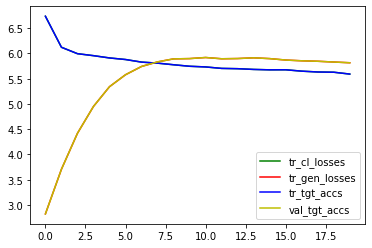

In [90]:
loader = ModelLoader('/content', 'product2real')

uda_generator = FeatureExtractor(n_classes, model=model, optimizer=optim, 
                                n_params_trained=n_params_trained, 
                                lr=lr, weight_decay=weight_decay, 
                                freeze=freeze, source_only=False)

symnet = ModelTrainer(uda_generator, loader, n_classes, n_epochs)

# Train on both source and target, validate only on target 
acc_uda = symnet.train_validate(source_train_loader, target_train_loader, target_val_loader)

In [ ]:
so_generator = FeatureExtractor(n_classes, model=model, optimizer=optim, 
                                n_params_trained=n_params_trained, 
                                lr=lr, weight_decay=weight_decay,
                                freeze=freeze, source_only=True)

source_only = SourceModelTrainer(so_generator, n_classes, n_epochs)

# Train only on source, validate only on target 
acc_so = source_only.train_validate(source_train_loader, target_val_loader)

In [ ]:
# Evaluate the performance gain between the two architectures 
overall_gain_perc = lambda acc_uda, acc_so: (abs(acc_so - acc_uda)/acc_so)*100
overall_gain_abs = lambda acc_uda, acc_so: (acc_uda - acc_so)

print(f'Percentage gain = {round(overall_gain_perc(acc_uda, acc_so), 2)} %')
print(f'Absolute gain = {round(overall_gain_perc(acc_uda, acc_so), 2)}')

##### Memory Tools

In [89]:
import gc

!nvidia-smi

if 'loader' in globals() or 'loader' in locals():
    print('Deleting loader...')
    del loader
if 'uda_generator' in globals() or 'uda_generator' in locals():
    print('Deleting generator...')
    del uda_generator
if 'symnet' in globals() or 'symnet' in locals():
    print('Deleting symnet...')
    del symnet

gc.collect()
torch.cuda.empty_cache()

!nvidia-smi

Sun Aug  7 10:38:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    34W / 250W |   1827MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------